### *DS 261: AI for Medical Image Analysis : Assignment 02*
*Submitted By: Aman Pawar, Mtech (1st Year), SR NO: 22761, Department of Bioengineering* 

*Note: Please install the following libraries if not already installed*

*Necessary Installs*<br/>
```!pip install numpy scipy matplotlib sklearn tqdm torchmetrics``` <br/>
```!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118```<br/>

*Installs for better visualizations*<br/>
```!pip install torchsummary graphviz torchview``` *Note on Windows you must install executable of graphviz*<br/> 

### *Task-1 : Classification of the Dataset using ResNet Model* 

In [12]:
# Doing necessary imports
import gc
import scipy.io
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=1200
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchmetrics as tm
from torchsummary import summary
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader, random_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}")

Working on cuda


In [13]:
# Building necessary Functions

def read_data(path):
    """Function to read data"""
    mat = scipy.io.loadmat(path)
    image_data = mat[list(mat.keys())[-1]]
    print("Reading Data...")
    print(f"Resolution of CT image : {image_data.shape[:2]} ")
    print(f"The number of CT images : {image_data.shape[2]}\n")
    return image_data

def visualize_data(data):
    """Function to visualize data"""
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, it in enumerate([100, 125, 150, 175, 200]): # Choosen Random images for display
        axes[i].imshow(data[:,:,it], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(get_object_name(data)+f'{i}')
    plt.show()

def get_object_name(obj):
    """Function to return name of object"""
    for name, value in globals().items():
        if value is obj:
            return name
    return None

def infection_ratio_cluster(data_ct, data_mask):
    """Function to compute the infection Ratio and cluster in 3 groups"""
    Normal_ct, Mild_ct, Severe_ct = [], [], []
    Normal_mask, Mild_mask, Severe_mask = [], [], []

    for i in range(data_mask.shape[2]):
        slice_data_mask = data_mask[:, :, i]
        slice_data_ct = data_ct[:,:,i]
        total_pixels = (slice_data_mask > 0).sum()
        infected_pixels = ((slice_data_mask > 0) & (slice_data_mask < 2)).sum()
        infection_ratio = infected_pixels / total_pixels * 100

        # Categorize the slice based on the infection ratio
        if infection_ratio == 0:
            Normal_mask.append(slice_data_mask)
            Normal_ct.append(slice_data_ct)
        elif 0 < infection_ratio <= 40:
            Mild_mask.append(slice_data_mask)
            Mild_ct.append(slice_data_ct)
        else:
            Severe_mask.append(slice_data_mask)
            Severe_ct.append(slice_data_ct)

    return np.array(Normal_mask), np.array(Normal_ct), np.array(Mild_mask), np.array(Mild_ct), np.array(Severe_mask), np.array(Severe_ct)


class CustomImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


#### *Reading the Dataset and plotting some sample images along with their masks*

Reading Data...
Resolution of CT image : (512, 512) 
The number of CT images : 3554

Reading Data...
Resolution of CT image : (512, 512) 
The number of CT images : 3554

Plotting CT Scan Data...


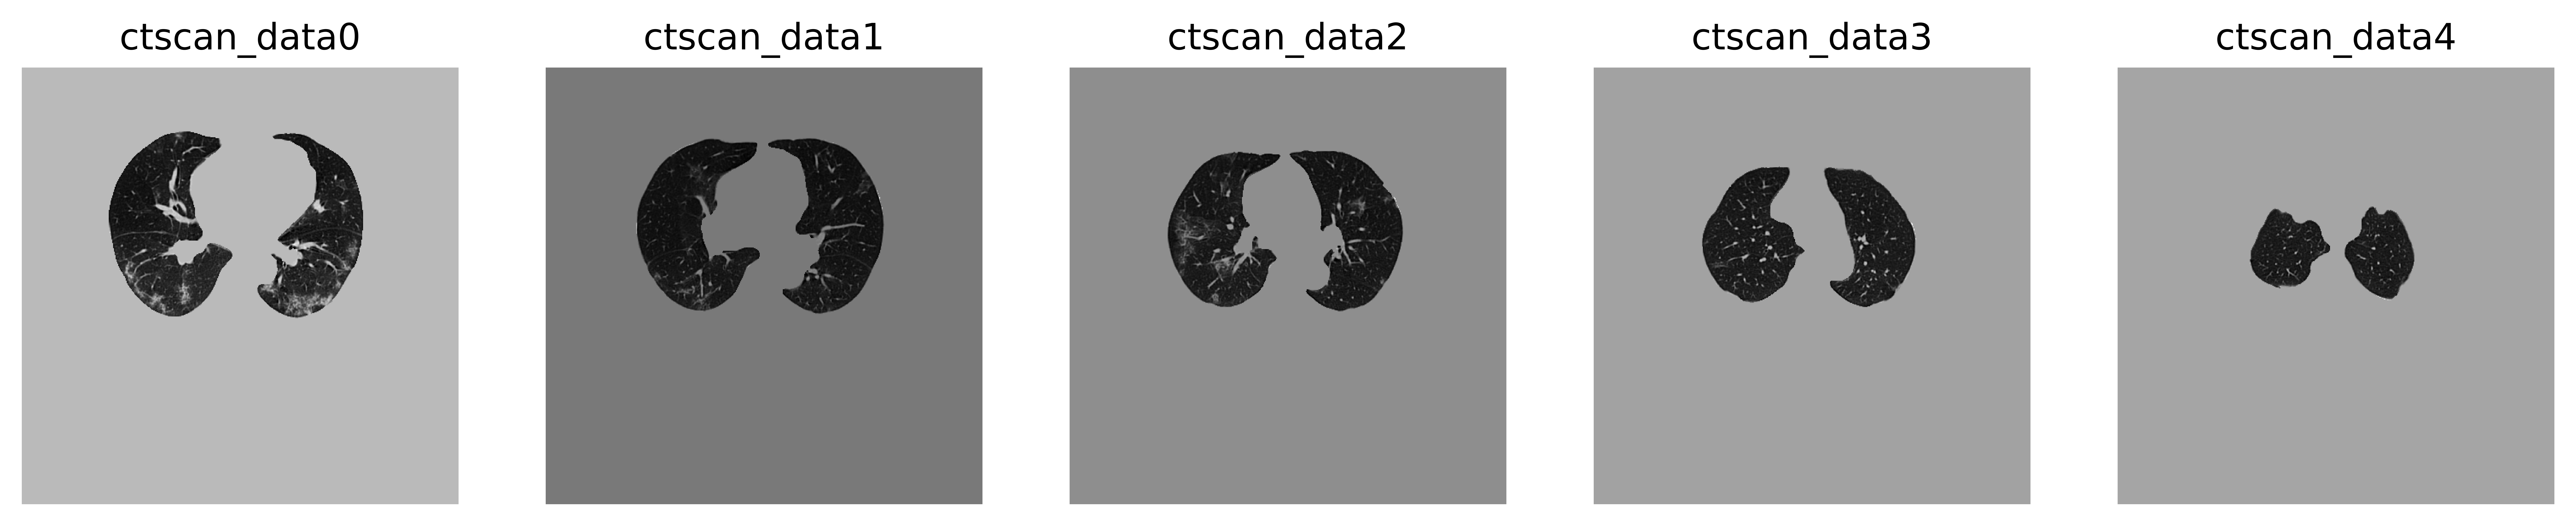

Plotting Coresponding Mask Data...


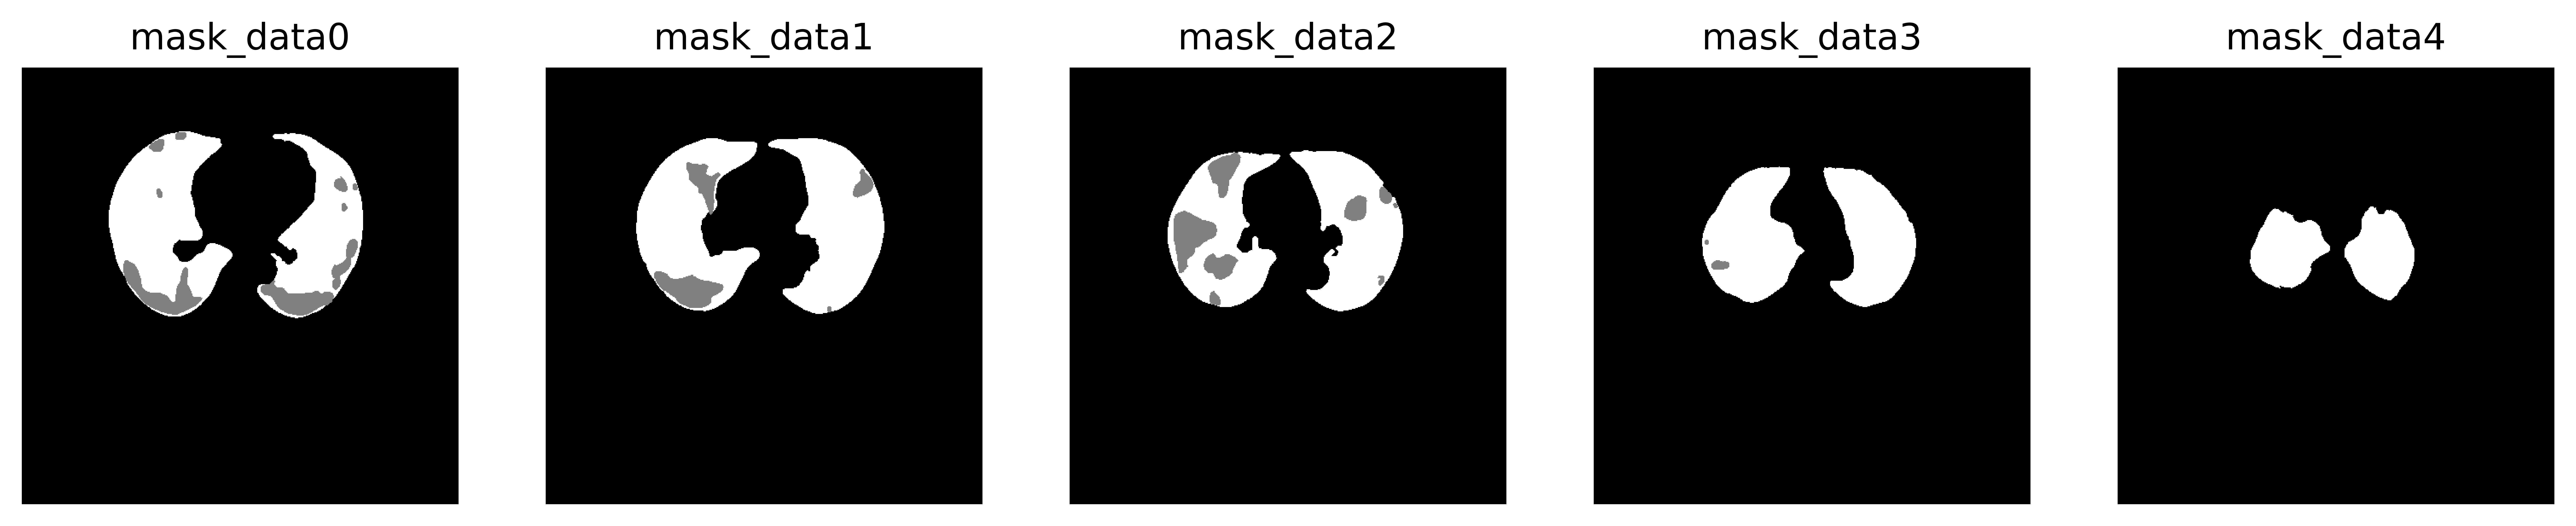

In [14]:
# Setting the path
path_ctscan = '/home/user2/AIMIA_AmanPawar/ctscan_hw1.mat'
path_mask = '/home/user2/AIMIA_AmanPawar/infmsk_hw1.mat'

# Reading the data
ctscan_data = read_data(path_ctscan)
mask_data = read_data(path_mask)

# Visualizing the Data
print(f"Plotting CT Scan Data...")
visualize_data(ctscan_data)
print(f"Plotting Coresponding Mask Data...")
visualize_data(mask_data)

#### *Task 1.1 : Categorizeing CT scans into three distinct groups Normal, Mild, and Severe based on the masks of the images*

In [15]:
# Clustering the data as per the infection ratio
Normal_mask, Normal_ct, Mild_mask, Mild_ct, Severe_mask, Severe_ct = infection_ratio_cluster(ctscan_data, mask_data)
print(f"Number of Normal CT : {len(Normal_mask)}\nNumber of Mild CT : {len(Mild_mask)}\nNumber of Severe CT : {len(Severe_mask)}")

Number of Normal CT : 1441
Number of Mild CT : 1954
Number of Severe CT : 159


#### *From the above observations we can clearly see that there is class imbalance in terms for the Normal, Mils and Severe CT Scans, Necessary class imbalance techniques should be added in order to augumnet the data better before deep learning tasks, but since it is not mentioned in the question we are not doing it, will attempt to learn a good model with this class imbalance itself.*

#### *Task 1.2 : Split the CT dataset into 70% training, 10% validation, and 20% testing*

In [16]:
# Creating Labels for the dataset
Normal_label = np.array([["Normal"]]*len(Normal_ct))
Mild_label = np.array([["Mild"]]*len(Mild_ct))
Severe_label = np.array([["Severe"]]*len(Severe_ct))

# Concatenate the image arrays and labels
all_images = np.concatenate((Normal_ct, Mild_ct, Severe_ct), axis=0)
all_labels = np.concatenate((Normal_label, Mild_label, Severe_label), axis=0)

# OHE the labels:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(all_labels)
all_labels = ohe.transform(all_labels)

print(f"All Images : {all_images.shape}, Coresponding Labels : {all_labels.shape}")

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.0,), (1.0,))  # Rescale pixel values to the range [0, 1]
])

dataset = CustomImageDataset(all_images, all_labels, transform=transform)
# Define the sizes for the training and testing sets
train_size = int(0.7 * len(dataset))
temp_size = len(dataset) - train_size
val_size = int(1/3 * temp_size)
test_size = temp_size - val_size

train_dataset, temp_dataset = random_split(dataset, [train_size, temp_size])
valid_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Data Loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

All Images : (3554, 512, 512), Coresponding Labels : (3554, 3)


Visualtizing Data from the DataLoader...


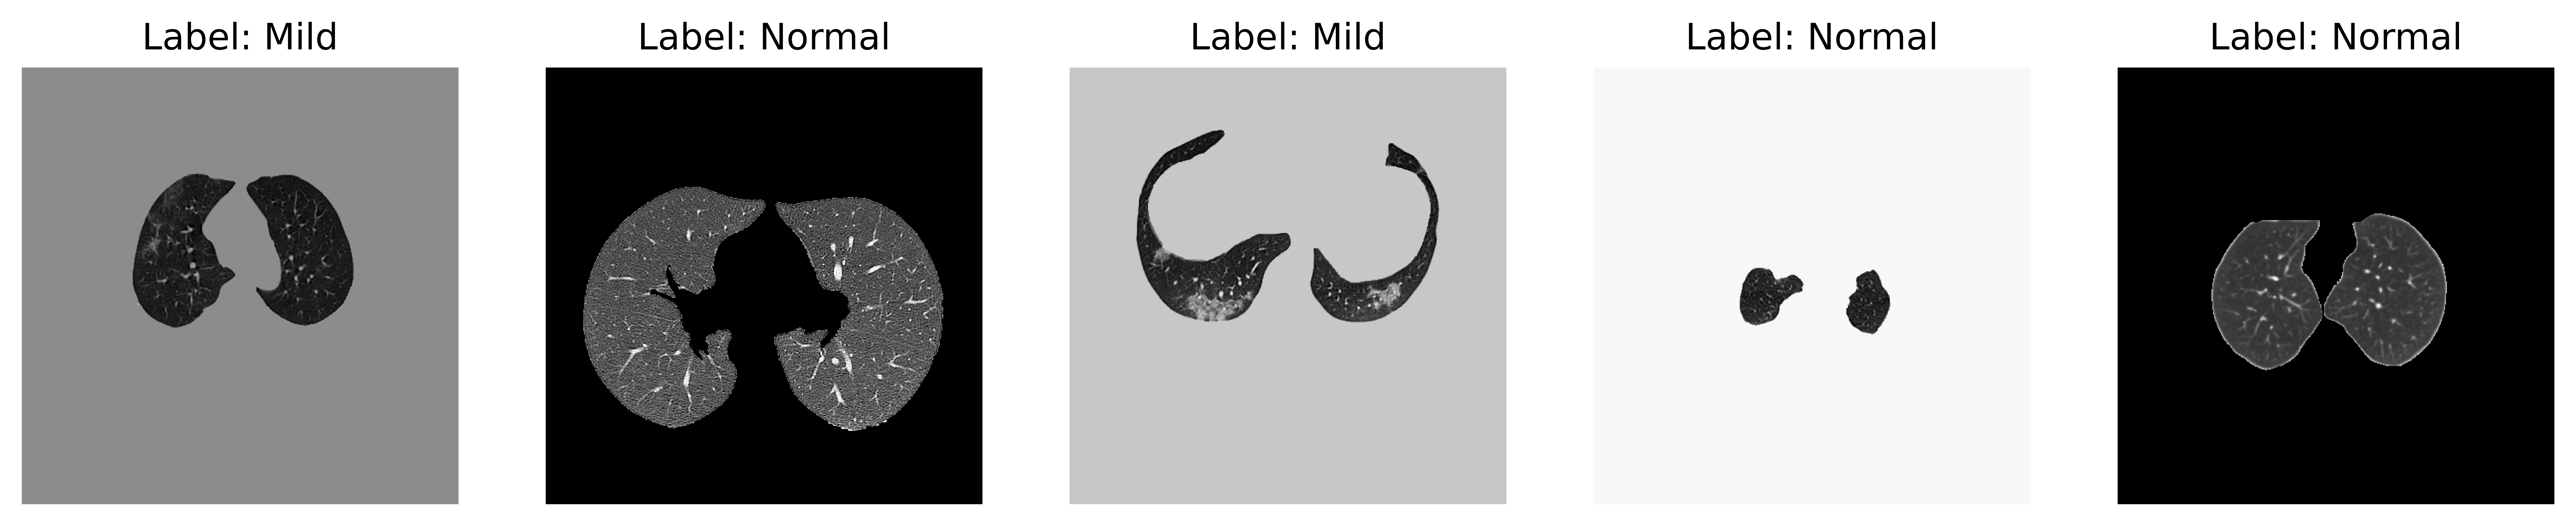

In [17]:
print("Visualtizing Data from the DataLoader...")
data_iterator = iter(train_loader)
batch = next(data_iterator)
images, labels = batch
# Display the first 5 images in a horizontal layout
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = images[i].numpy()
    image = np.moveaxis(image, 0, -1)  # Transpose to HWC format
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {ohe.inverse_transform(np.reshape(labels[i], (1,-1)))[0][0]}")
    plt.axis('off')

plt.show()


#### *Task 1.3 : Train a ResNet model to classify the provided CT scans and report the performance metrics, including sensitivity, specificity, and accuracy*

In [18]:
# Define a custom ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=1)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, num_classes)
        

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return torch.softmax(x, dim=1)

# Define the basic building block for the ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out


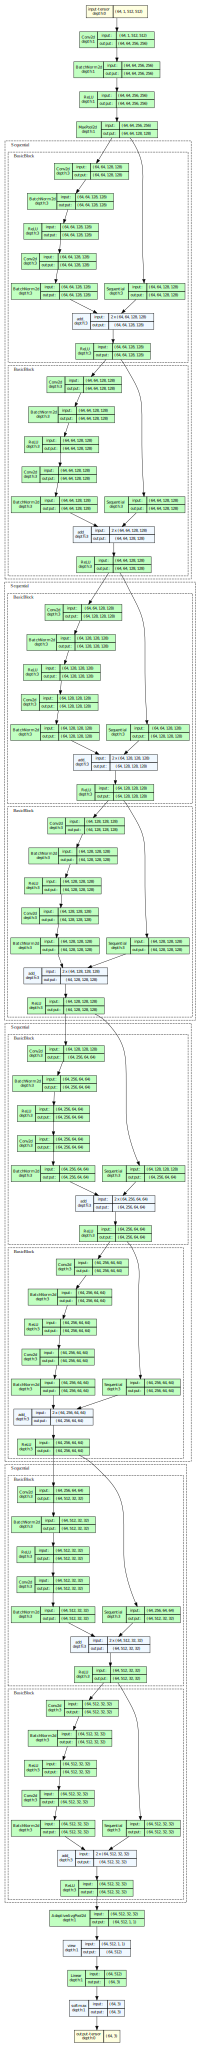

In [19]:
# Visualizing Graph
model = ResNet(3)
model_graph = draw_graph(model, input_size=(64,1,512,512), expand_nested=True)
model_graph.visual_graph

In [20]:
summary(model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,200
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [21]:
# Lists to store training and validation loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []
valid_loss_history = []
valid_accuracy_history = []

# Set up model checkpointing
best_valid_accuracy = 0.0
checkpoint_path = '/home/user2/AIMIA_AmanPawar/model_weights/resnet_task1_checkpoint.pth'

# Define hyperparameters
num_classes = 3
learning_rate = 0.001
num_epochs = 50

# Initialize the model
model = ResNet(num_classes)
model= nn.DataParallel(model)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.,1.25,2.25])).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
acc_ = tm.Accuracy(task="multiclass", num_classes=3).to(device)
f1 = tm.F1Score(task="multiclass", num_classes=3).to(device)

Epoch 1/Validation: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s, accuracy=58.6, f1_score=0.5858586, loss=0.223] 


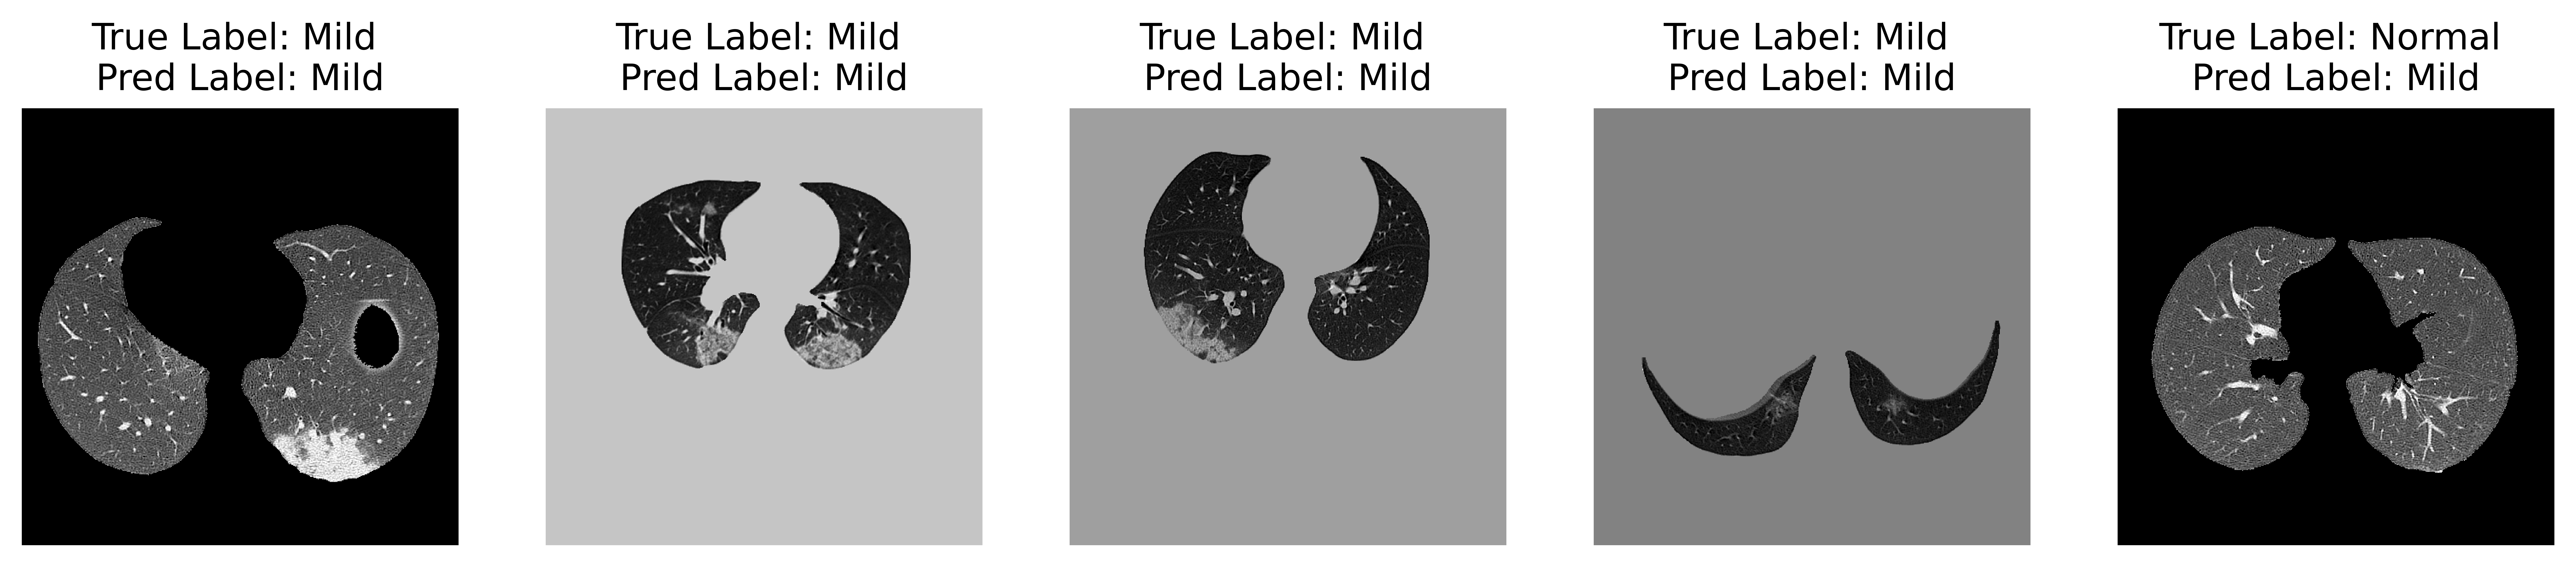

Epoch 21/Validation: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s, accuracy=86.9, f1_score=0.86868685, loss=0.167]


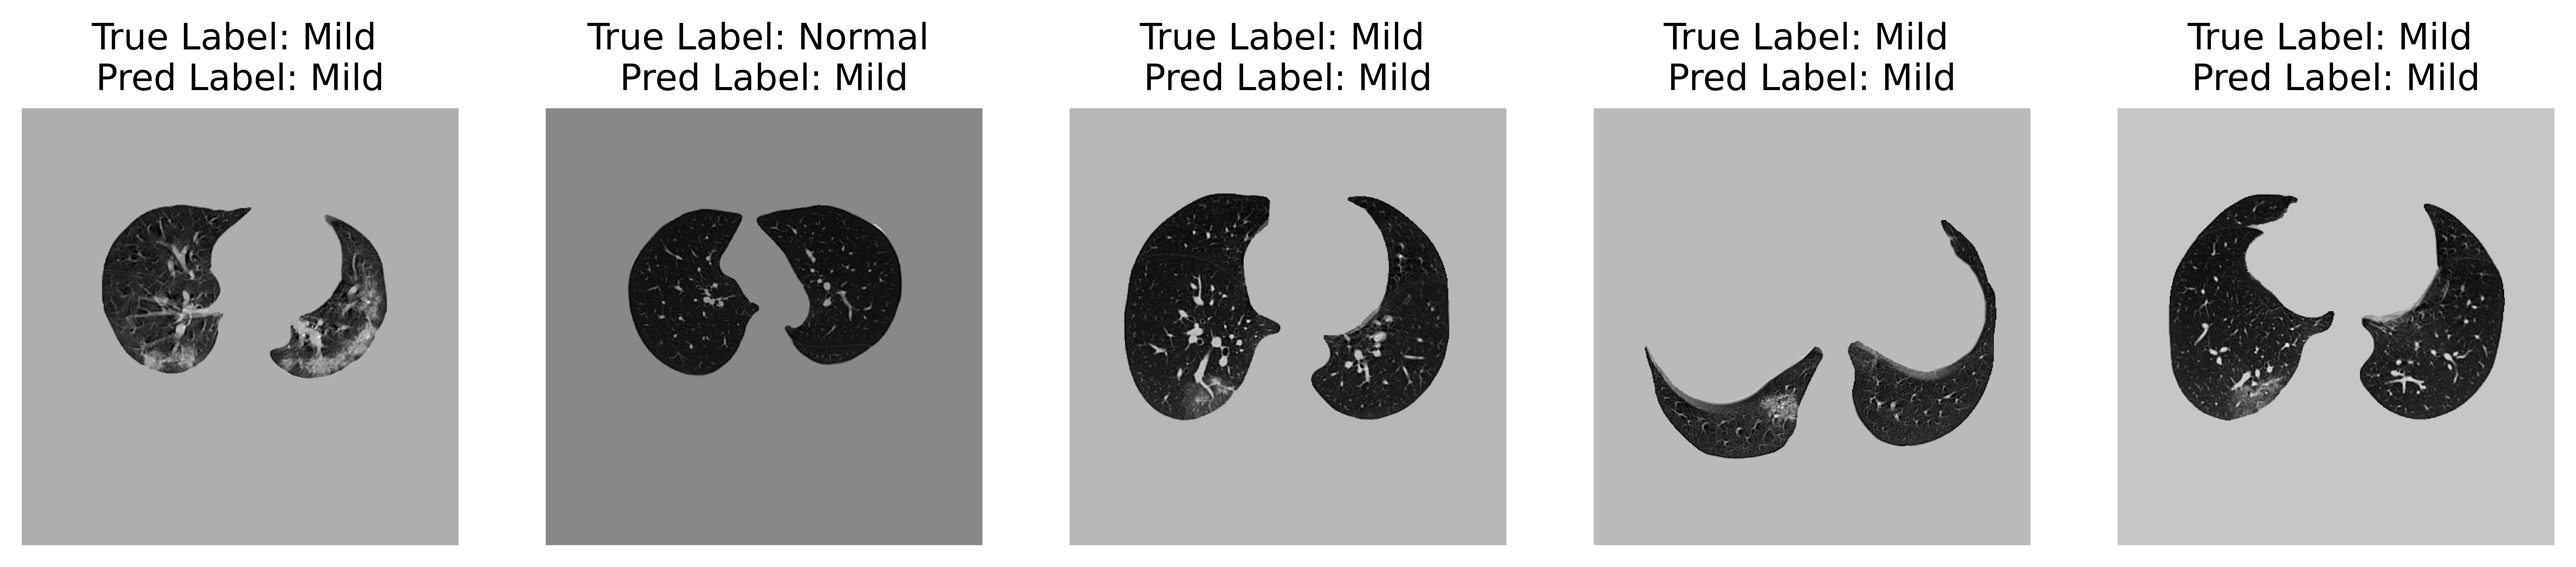

Epoch 41/Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s, accuracy=82.8, f1_score=0.82828283, loss=0.169]


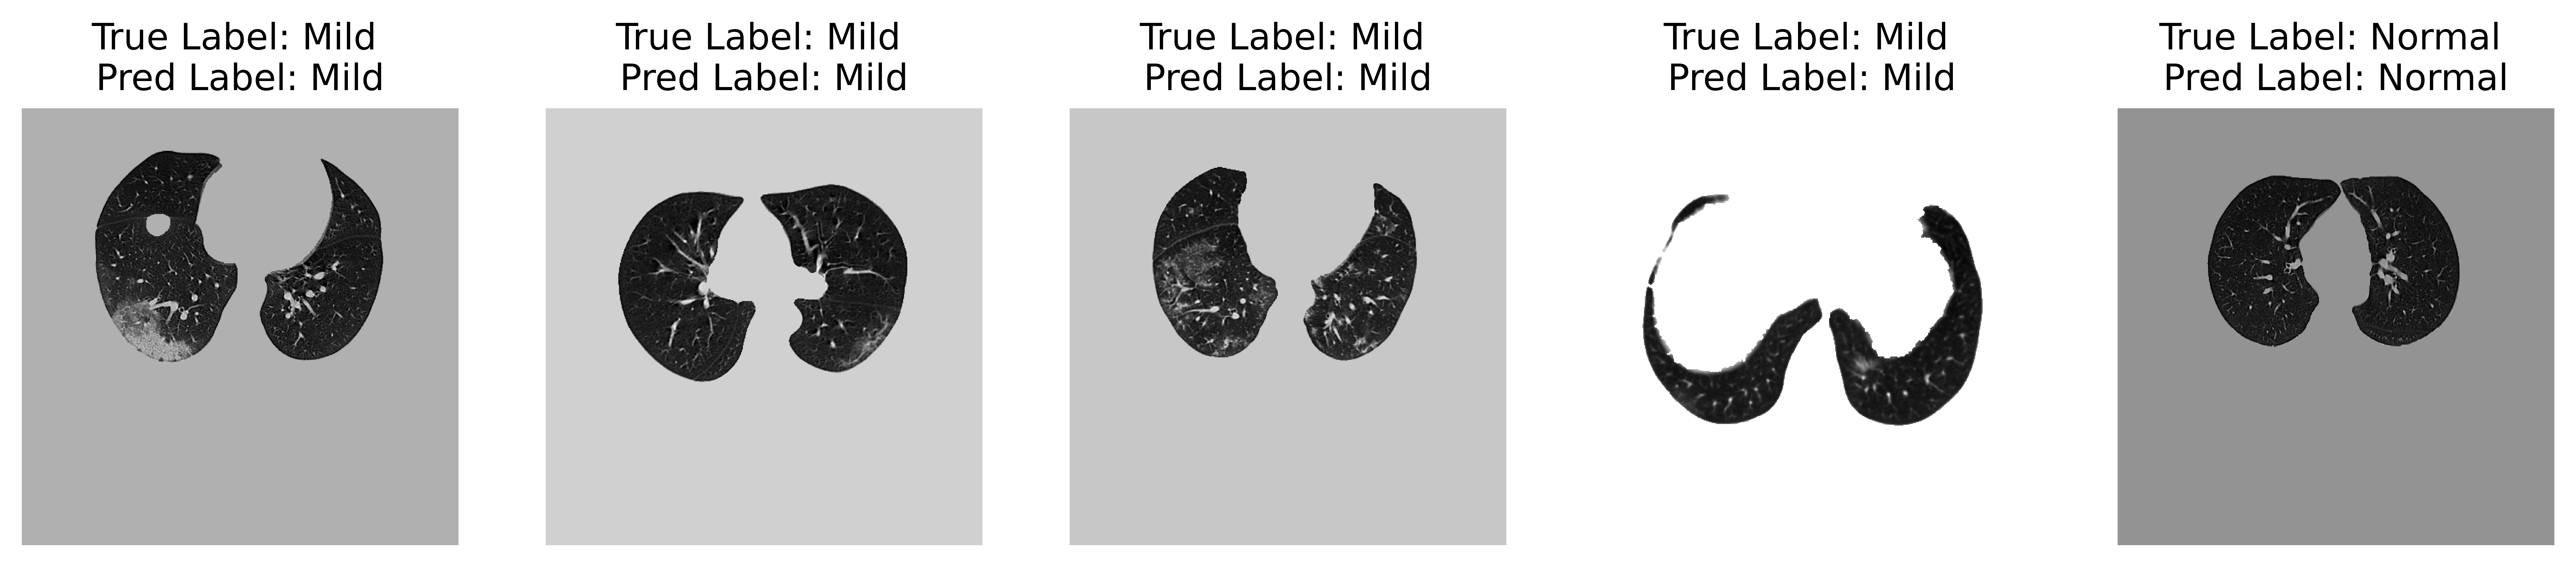

Epoch 50/Validation: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s, accuracy=84.8, f1_score=0.8484849, loss=0.166] 

CPU times: user 1h 20min 34s, sys: 3h 3min 56s, total: 4h 24min 31s
Wall time: 13min 56s


In [22]:
%%time
# Training loop with tqdm
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    # Wrap the train_loader with tqdm for a progress bar
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/Training', position=0)
    for i, (images, labels) in enumerate(train_loader_iter):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_loss = train_running_loss / (i + 1)
        
        outputs, labels = torch.argmax(outputs,1), torch.argmax(labels,1)
        train_accuracy = 100* acc_(outputs, labels).cpu().numpy()
        f_train = f1(outputs, labels).cpu().numpy()
        train_loader_iter.set_postfix(loss=train_loss, accuracy=train_accuracy, f1_score = f_train)
        
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation loop with tqdm
    model.eval()  # Set the model to evaluation mode
    valid_correct = 0
    valid_total = 0
    valid_running_loss = 0.0

    # Wrap the valid_loader with tqdm for a progress bar
    valid_loader_iter = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/Validation', position=0)
    with torch.no_grad():
        for images, labels in valid_loader_iter:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()

            valid_loss = valid_running_loss / (i + 1)
            outputs, labels = torch.argmax(outputs,1), torch.argmax(labels,1)
            valid_accuracy = 100* acc_(outputs, labels).cpu().numpy()
            f_valid = f1(outputs, labels).cpu().numpy()
            valid_loader_iter.set_postfix(loss=valid_loss, accuracy=valid_accuracy, f1_score = f_valid)
            
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    # Save the model checkpoint if the current validation accuracy is the best so far
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid_accuracy': best_valid_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)
        
    if epoch%20==0:
        # Display input image, predicted mask, and ground truth
        data_iterator = iter(valid_loader)
        batch = next(data_iterator)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            sample_outputs = model(images)

        # pred = torch.argmax(sample_outputs, 1)
        # Display the first 5 images in a horizontal layout
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            image = images[i].cpu().numpy()
            image = np.moveaxis(image, 0, -1)  # Transpose to HWC format
            plt.imshow(image, cmap="gray")
            plt.title(f"True Label: {ohe.inverse_transform(np.reshape(labels[i].cpu(), (1,-1)))[0][0]} \nPred Label: {ohe.inverse_transform(np.reshape(sample_outputs[i].cpu(), (1,-1)))[0][0]}")
            plt.axis('off')

        plt.show()

        del images, labels, sample_outputs
        torch.cuda.empty_cache()
        gc.collect()

In [23]:
# Plot loss and accuracy curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history,'--or', label='Training Loss', markersize=2)
plt.plot(valid_loss_history,'--ob', label='Validation Loss', markersize=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history,'--or', label='Training Accuracy', markersize=2)
plt.plot(valid_accuracy_history,'--ob', label='Validation Accuracy', markersize=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Testing: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


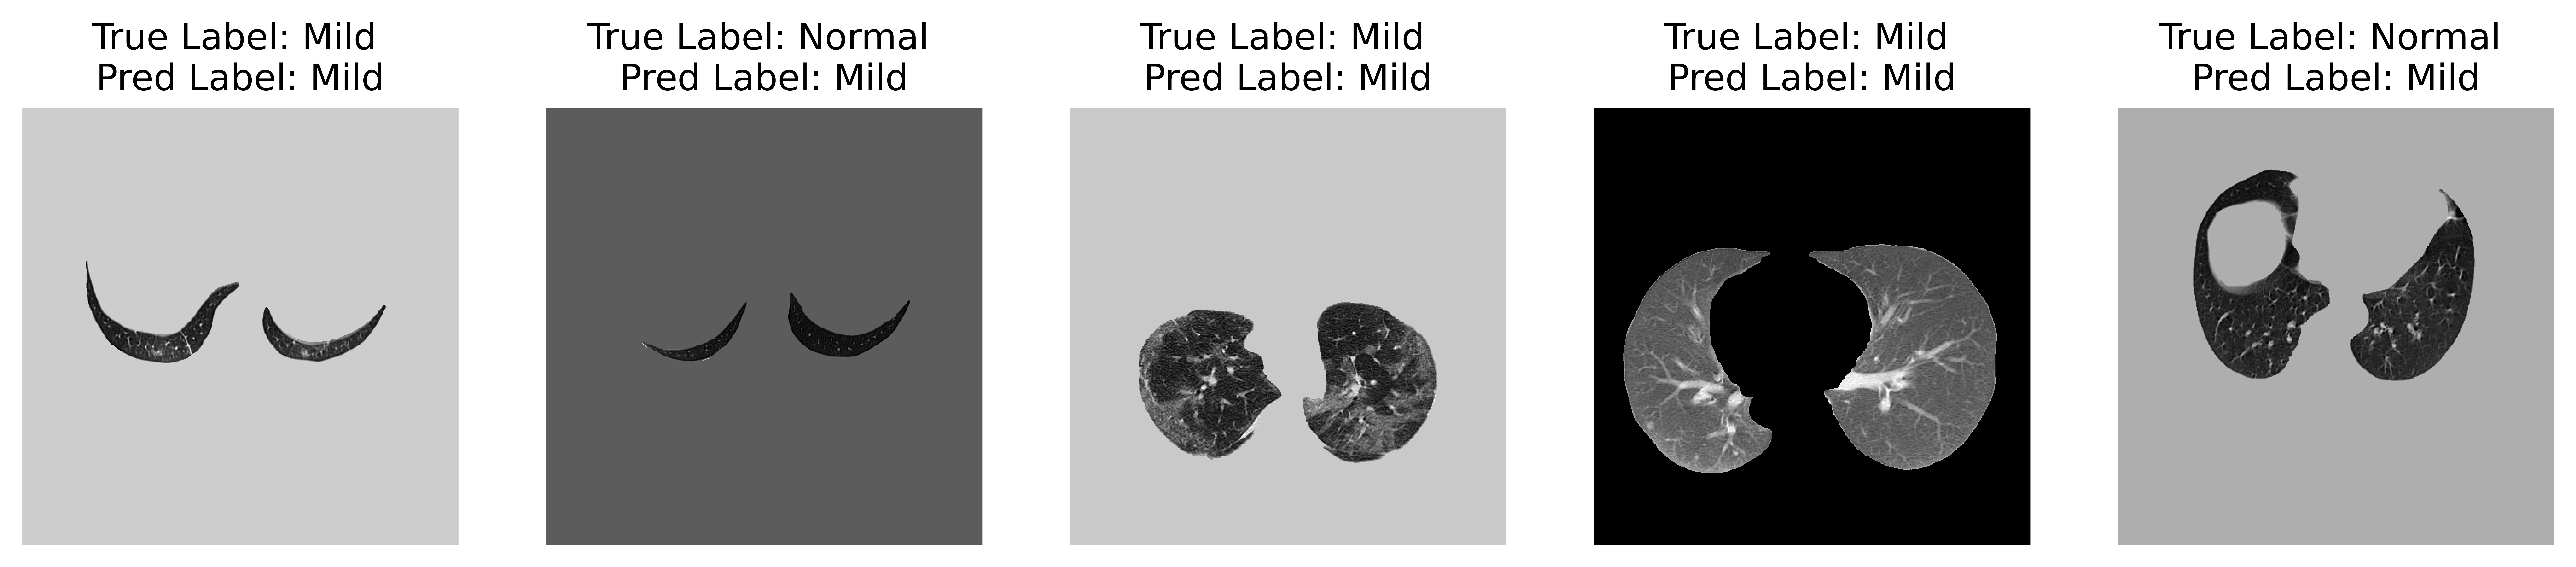

Test Dataset: 
Accuracy: 88.06%
Sensitivity: 0.92
Specificity: 0.92
CPU times: user 24 s, sys: 53 s, total: 1min 17s
Wall time: 4.6 s


In [24]:
%%time
# Loading the model:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_valid_accuracy = checkpoint['best_valid_accuracy']


# Test the model
model.eval()
correct = 0
total = 0
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
test_loader_iter = tqdm(test_loader, desc='Testing', position=0)

with torch.no_grad():
    for images, labels in test_loader_iter:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels,1)).sum().item()
      
        for i in range(len(predicted)):
            confusion_matrix[torch.argmax(labels,1)[i], predicted[i]] += 1
            
    # Display the first 5 images in a horizontal layout
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        image = images[i].cpu().numpy()
        image = np.moveaxis(image, 0, -1)  # Transpose to HWC format
        plt.imshow(image, cmap="gray")
        plt.title(f"True Label: {ohe.inverse_transform(np.reshape(labels[i].cpu(), (1,-1)))[0][0]} \nPred Label: {ohe.inverse_transform(np.reshape(outputs[i].cpu(), (1,-1)))[0][0]}")
        plt.axis('off')

    plt.show()

    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect()

accuracy = 100 * correct / total
sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

print(f'Test Dataset: ')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
